# Deep Learning in Waste Management

![alt text](https://raw.githubusercontent.com/krithikaceg/waste_management/master/Waste-Management-1.png)

Waste Management is a huge problem in any country, especially where the population is growing. One of the major problems is the huge amount of waste that goes to landfills. According to CNBC, San Francisco has diverted 80% of its waste from going to landfills with an aim to achieve zero waste. The city has done this with the help of its waste management company, Recology. With the help of the blue bins, it collects the recyclable waste from all around the city.

Even though most of the time people throw the waste in the appropriate waste bin, sometimes people tend to throw it in incorrect bin which makes the waste segregation difficult. This Project is aimed towards helping the recycling centers in separating non-recyclable materials using Machine Learning techniques.


**Importing library**

In [0]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

## Data Ingestion

All the waste material images are collected and organized under their respective folders. For example, cardboard images are organized under cardboard folder inside dataset-resized. This is how each images is being labelled.

In [0]:
!wget https://raw.githubusercontent.com/krithikaceg/waste_management/master/dataset-resized_new.zip
zip_images = 'dataset-resized_new.zip'
import zipfile
zip_ref = zipfile.ZipFile(zip_images, 'r')
zip_ref.extractall("wm-dataset")
zip_ref.close()


--2019-06-24 02:23:51--  https://raw.githubusercontent.com/krithikaceg/waste_management/master/dataset-resized_new.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41804264 (40M) [application/zip]
Saving to: ‘dataset-resized_new.zip.1’

dataset-resized_new 100%[===================>]  39.87M   151MB/s    in 0.3s    

2019-06-24 02:23:52 (151 MB/s) - ‘dataset-resized_new.zip.1’ saved [41804264/41804264]



## EDA

In [0]:

path_to_images = 'wm-dataset/dataset-resized_new/*/*.jpg'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
print(set(traininglabels))
traininglabels = pd.DataFrame(traininglabels)

{'glass', 'paper', 'cardboard', 'metal', 'plastic'}


### Classifications

Classes['cardboard' 'glass' 'metal' 'paper' 'plastic']
5


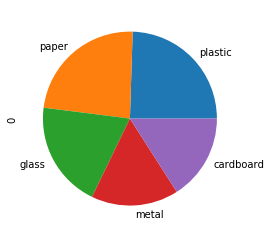

In [0]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

### Sample Images from training set

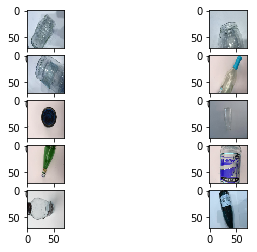

In [0]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(trainingset[i])

### Masking images (for the machine to recognise and learn)

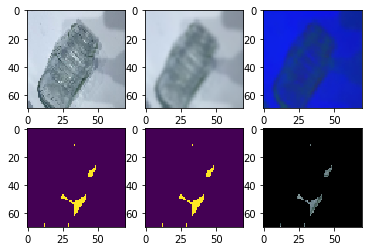

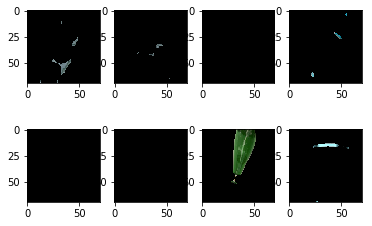

In [0]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

## Model

In [0]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [0]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

### Convolutional Neural Network for Image predictions

In [0]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

W0624 02:24:50.894318 139702823270272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 02:24:50.946183 139702823270272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 02:24:50.956344 139702823270272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 02:24:51.019882 139702823270272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 02:24:51.021295 1397028232

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

In [0]:
print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_test, y_test))  # Evaluate on test set

2274/2274 [==============================] - 80s 35ms/step
[1.6093390908488707, 0.24802110817941952]
253/253 [==============================] - 9s 35ms/step
[1.6093223396497283, 0.22134387339999081]


### Prediction

In [0]:
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[33  5  0  1  1]
 [19 15  4  1 11]
 [24 12  2  0  3]
 [34 21  0  0  5]
 [40 14  2  0  6]]


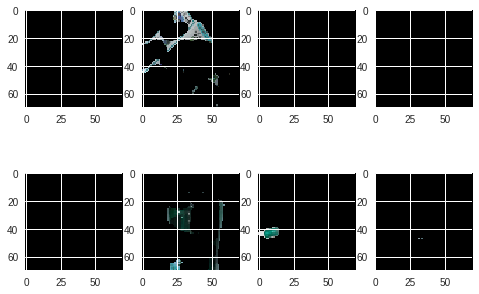

In [0]:
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(x_test[i])
  
  

In [0]:
for i in range(8):
  print("Predicted: " + labels.classes_[y_class[i]])
  print("Actual class: "+labels.classes_[y_check[i]])

Predicted: cardboard
Actual class: trash
Predicted: glass
Actual class: paper
Predicted: cardboard
Actual class: glass
Predicted: cardboard
Actual class: plastic
Predicted: cardboard
Actual class: paper
Predicted: metal
Actual class: glass
Predicted: glass
Actual class: glass
Predicted: metal
Actual class: metal


## Keras pre-trained VGG 16 model

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()


In [4]:
!wget https://raw.githubusercontent.com/krithikaceg/waste_management/master/plastic_bottle_trash.jpg
# load an image from file
image = load_img('plastic_bottle_trash.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

--2019-06-25 19:08:37--  https://raw.githubusercontent.com/krithikaceg/waste_management/master/plastic_bottle_trash.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994 (7.8K) [image/jpeg]
Saving to: ‘plastic_bottle_trash.jpg’

plastic_bottle_tras 100%[===================>]   7.81K  --.-KB/s    in 0s      

2019-06-25 19:08:37 (114 MB/s) - ‘plastic_bottle_trash.jpg’ saved [7994/7994]

40960/35363 [==================================] - 0s 0us/step
pop_bottle (18.17%)


## Prediction using Google AutoML Vision

![alt text](https://raw.githubusercontent.com/krithikaceg/waste_management/master/google_automl_vision_prediction.png)

## Conclusion
Even though it has classified, the result is not satisfactory. 

**Challenges:**

Different to classify certain items such as metal cup, paper cup, plastic cup which involves human intellect.


**Couple of suggestions:**

1. We are not sure if the training data is sufficient or trains the model well. May be 2500 images is not enough or doesn't provide variety for our model to distinguish.
- Train with more number of number of variety of images.

2. Test the images with Amazon ML or Google Vision.

3. We are adding only three layers here. We can add more layers for better training and classification.

4. May be Neural networks is not good at classifying these images. Try different technologies.


**Next Steps:**
1. Collect more images and train our model. 

2. Use the established/proven tools to classify our images to check if the input data is sufficient.

3. Leverage deep learning technologies better.

4. Try different technologies until we achieve a better score.
